# Testing XLuminA: 

(1) *Diffractio vs XLuminA propagation functions.*

(2) *JAX (autodiff-based ADAM) vs SciPy's (BFGS) optimization using XLuminA.*

In [27]:
import time
import os
import sys

# Setting the path for XLuminA modules:
current_path = os.path.abspath(os.path.join('..'))
module_path = os.path.join(current_path)

if module_path not in sys.path:
    sys.path.append(module_path)

## (1) Speed test on propagation functions:

    1. Scalar Rayleigh-Sommerfeld (RS)
    2. Scalar Chirped z-transform (CZT)
    3. Vectorial Rayleigh-Sommerfeld (VRS)
    4. Vectorial Chirped z-transform (VCZT)
    
*Test for a computational window size of 2048x2048. You can change the sampling via "resolution".* 

In [2]:
resolution = 2048

### Diffractio: *runs on CPU device*

In [3]:
from diffractio import np, degrees, um, mm
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.vector_sources_XY import Vector_source_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.vector_fields_XY import Vector_field_XY

In [4]:
# System specs:
wavelength = .6328 * um
w0 = (1200*um , 1200*um)
x = np.linspace(-15 * mm, 15 * mm, resolution)
y = np.linspace(-15 * mm, 15 * mm, resolution)
x_out = np.linspace(-15 * mm, 15 * mm, resolution)
y_out = np.linspace(-15 * mm, 15 * mm, resolution)

#### Scalar optics

In [5]:
ls = Scalar_source_XY(x, y, wavelength, info='Light source')
ls.gauss_beam(r0=(0 * um, 0 * um), w0=w0, z0=(0,0), A=1, theta=0 * degrees, phi=0 * degrees)

# Rayleigh-Sommerfeld:
tic = time.perf_counter()
ls_propagated = ls.RS(z=5*mm)
print("Time taken for RS propagation - in seconds", time.perf_counter() - tic)

# Chirped z-transform:
tic = time.perf_counter()
ls_propagated = ls.CZT(z=5*mm, xout=x_out, yout=y_out, verbose=False)
print("Time taken for CZT propagation - in seconds", time.perf_counter() - tic)

Time taken for RS propagation - in seconds 4.051304008811712
Time taken for CZT propagation - in seconds 1.9945963714271784


#### Vectorial optics

In [6]:
vls = Vector_source_XY(x, y, wavelength=wavelength, info='Light source polarization')
vls.constant_polarization(u=ls, v=(1, 0), has_normalization=False, radius=(15*mm, 15*mm)) 

# Rayleigh-Sommerfeld:
tic = time.perf_counter()
vls.VRS(z=5*mm, n=1, new_field=False, verbose=False, amplification=(1, 1))
print("Time taken for VRS propagation - in seconds", time.perf_counter() - tic)

# Chirped z-transform:
tic = time.perf_counter()
vls.CZT(z=5*mm, xout=x_out, yout=y_out, verbose=False)
print("Time taken for VCZT propagation - in seconds", time.perf_counter() - tic)

Time taken for VRS propagation - in seconds 12.461026553064585
Time taken for VCZT propagation - in seconds 6.241402745246887


### XLuminA: *runs on CPU and GPU*

*If you are running this notebook in a* **CPU** *node, the software will automatically fall back to CPU. You don't need to change anything :)*

*If you are running this notebook in a* **GPU** *node, you can enable the* **CPU** *via adding these lines of code at the beginning of the cell:*

    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '[]'
    
*For XLuminA's test we run the functions* **twice** *: the 1st time a function that contains the* **just-in-time decorator** *(@jit) is called, JAX takes extra time to store the function in cache. The second (and subsequent) runs just call the pre-compiled function so the computation is faster.*

In [3]:
from xlumina.__init__ import mm
from xlumina.wave_optics import *
from xlumina.vectorized_optics import *
from xlumina.optical_elements import *
from xlumina.loss_functions import *
from xlumina.toolbox import space
import jax.numpy as jnp

wavelength = .6328 * um
w0 = (1200*um , 1200*um)
x, y = space(15*mm, resolution)
x_out, y_out = jnp.array(space(15*mm, resolution))

ModuleNotFoundError: No module named 'xlumina'

#### Scalar optics

In [5]:
gb = LightSource(x, y, wavelength)
gb.gaussian_beam(w0=w0, E0=1)

# Rayleigh-Sommerfeld:
tic = time.perf_counter() 
ls_propagated = gb.RS_propagation(z=5*mm)
print("Time taken for 1st RS propagation - in seconds", time.perf_counter() - tic)

tic = time.perf_counter() 
ls_propagated = gb.RS_propagation(z=5*mm)
print("Time taken for 2nd RS propagation - in seconds", time.perf_counter() - tic)

# Chirped z-transform:
tic = time.perf_counter() 
ls_propagated = gb.CZT(z=5*mm, xout=x_out, yout=y_out)
print("Time taken for 1st CZT propagation - in seconds", time.perf_counter() - tic)

tic = time.perf_counter() 
ls_propagated = gb.CZT(z=5*mm, xout=x_out, yout=y_out)
print("Time taken for 2nd CZT propagation - in seconds", time.perf_counter() - tic)

Time taken to perform one RS propagation (in seconds): 1.6592820473015308
Time taken for 1st RS propagation - in seconds 1.6601537950336933
Time taken to perform one RS propagation (in seconds): 0.009246926754713058
Time taken for 2nd RS propagation - in seconds 0.00949065387248993
Time taken to perform one CZT propagation (in seconds): 2.8923826217651367
Time taken for 1st CZT propagation - in seconds 2.8929686844348907
Time taken to perform one CZT propagation (in seconds): 0.030335675925016403
Time taken for 2nd CZT propagation - in seconds 0.030557945370674133


#### Vectorial optics

In [6]:
gb_lp = PolarizedLightSource(x, y, wavelength)
gb_lp.gaussian_beam(w0=w0, jones_vector=(1, 0))

# Rayleigh-Sommerfeld:
tic = time.perf_counter() 
gb_propagated = gb_lp.VRS_propagation(z=5*mm)
print("Time taken for 1st VRS propagation - in seconds", time.perf_counter() - tic)

tic = time.perf_counter() 
gb_propagated = gb_lp.VRS_propagation(z=5*mm)
print("Time taken for 2nd VRS propagation - in seconds", time.perf_counter() - tic)

# Chirped z-transform:
tic = time.perf_counter() 
gb_propagated = gb_lp.VCZT(z=5*mm, xout=x_out, yout=y_out)
print("Time taken for 1st VCZT propagation - in seconds", time.perf_counter() - tic)

tic = time.perf_counter() 
gb_propagated = gb_lp.VCZT(z=5*mm, xout=x_out, yout=y_out)
print("Time taken for 2nd VCZT propagation - in seconds", time.perf_counter() - tic)

Time taken to perform one VRS propagation (in seconds): 1.3885535262525082
Time taken for 1st VRS propagation - in seconds 1.3888123966753483
Time taken to perform one VRS propagation (in seconds): 0.14746328070759773
Time taken for 2nd VRS propagation - in seconds 0.14762601256370544
Time taken to perform one VCZT propagation (in seconds): 1.1658967472612858
Time taken for 1st VCZT propagation - in seconds 1.1661826558411121
Time taken to perform one VCZT propagation (in seconds): 0.07554645836353302
Time taken for 2nd VCZT propagation - in seconds 0.07574645429849625


## (2) Comparison of XLuminA's autodiff optimization with numerical methods.

*For this test we code an optical setup consisting of a gaussian beam interacting with a spatial light modulator (SLM) after some propagation. The ground truth is a gaussian beam with a spiral phase. The loss function is the mean squared error (MSE) of the phase between the outcome of the setup and the ground truth. Via optimization, we aim to rediscover the phase mask in the SLM device.*

*We optimize using: (1) Diffractio's optical simulator with SciPy's BFGS optimizer (computing the gradients* **numerically** *) and (2) XLuminA with the ADAM optimizer from JAX, which due to autodiff, computes the gradients* **analytically**. *We run the optimization for different* **resolution**.

In [38]:
resolution = 10

### XLuminA with autodiff optimization (ADAM):

In [39]:
from xlumina.__init__ import um, nm, mm, degrees, radians
from xlumina.wave_optics import *
from xlumina.optical_elements import SLM
from xlumina.toolbox import space
import jax.numpy as jnp
import numpy as np

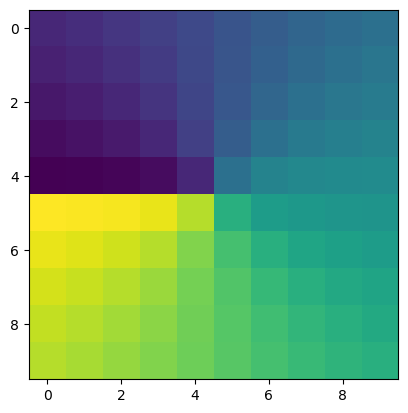

In [40]:
wavelength = 650*nm
x_total = 1000*um 
x, y = space(x_total, resolution)
shape = jnp.shape(x)[0]

# Light source specs
w0 = (1200*um , 1200*um)
gb = LightSource(x, y, wavelength)
gb.gaussian_beam(w0=w0, E0=1)
gb_gt = ScalarLight(x, y, wavelength)
# Set spiral phase for the ground truth
phase_mask = jnp.arctan2(gb.Y,gb.X)
gb_gt.field = gb.field * jnp.exp(1j * phase_mask)

plt.imshow(phase_mask)

In [41]:
# Define the setup
def setup(gb, parameters):
    gb_propagated = gb.RS_propagation(z=25000*mm)
    gb_modulated, _ = SLM(gb, parameters, gb.x.shape[0])
    return gb_modulated

def mse_phase(input_light, target_light):
    return jnp.sum((jnp.angle(input_light.field) - jnp.angle(target_light.field)) ** 2) / resolution**2
def loss(parameters):
    out = setup(gb, parameters)
    loss_val = mse_phase(out, gb_gt)
    return loss_val

[gpu(id=0), gpu(id=1)]
Starting Optimization
Stopping criterion: no improvement in loss value for 50 steps
Best loss: 9.932328871996077e-30 at step 5741; actual step 5800
Time taken to optimize one sample - in seconds 3.0919757653027773


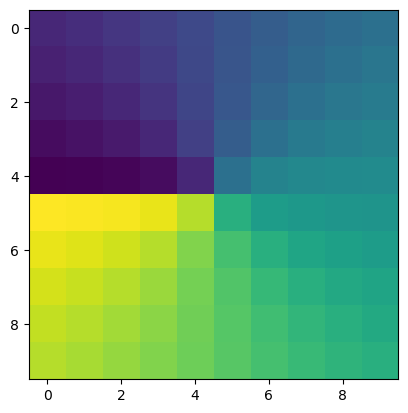

In [45]:
import jax
from jax import grad, jit
from jax.example_libraries import optimizers

# Print device info (GPU or CPU)
print(jax.devices(), flush=True)

# Define the update:
@jit
def update(step_index, optimizer_state):
    # define single update step
    parameters = get_params(optimizer_state)
    # Call the loss function and compute the gradients
    computed_loss = loss_value(parameters)
    computed_gradients = grad(loss_value, allow_int=True)(parameters)

    return opt_update(step_index, computed_gradients, optimizer_state), computed_loss, computed_gradients

# Define the loss function and compute its gradients:
loss_value = jit(loss)

# Optimizer settings
STEP_SIZE = 0.1
num_iterations = 50000
n_best = 50
best_loss = 1e10
best_params = None
best_step = 0

# Init parameters:
init_params = jnp.array([np.random.uniform(-jnp.pi, jnp.pi, (resolution, resolution))], dtype=jnp.float64)
   
# Define the optimizer and initialize it
opt_init, opt_update, get_params = optimizers.adam(STEP_SIZE)
opt_state = opt_init(init_params)

print('Starting Optimization', flush=True)
tic = time.perf_counter()
        
# Optimize in a loop
for step in range(num_iterations):
        
    opt_state, loss_value, gradients = update(step, opt_state)

    if loss_value < best_loss:
        best_loss = loss_value
        best_params = get_params(opt_state)
        best_step = step

    # Stopping criteria:
    if step % 100 == 0:
        if step - best_step > n_best:
            print(f'Stopping criterion: no improvement in loss value for {n_best} steps')
            break

print(f'Best loss: {best_loss} at step {best_step}; actual step {step}')
print("Time taken to optimize one sample - in seconds", time.perf_counter() - tic)

plt.imshow(best_params[0])

### Diffractio with SciPy's optimizer (BFGS):

In [46]:
from diffractio import np, degrees, um, mm, nm
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_fields_XY import Scalar_field_XY

In [47]:
# Light source settings
wavelength = .6328 * um
w0 = (1200*um , 1200*um)

wavelength = 650*nm
x_total = 1000*um 
x = np.linspace(-x_total , x_total , resolution)
y = np.linspace(-x_total , x_total , resolution)
gb = Scalar_source_XY(x, y, wavelength, info='Light source')
gb.gauss_beam(r0=(0 * um, 0 * um), w0=w0, z0=(0,0), A=1, theta=0 * degrees, phi=0 * degrees)

# Spiral phase for ground truth
gb_gt = Scalar_field_XY(x, y, wavelength)
phase_mask = np.arctan2(gb.Y,gb.X)
gb_gt.u = gb.u * np.exp(1j * phase_mask)

In [57]:
# Optical setup
def setup(gb, parameters):
    gb_propagated = gb.RS(25000*mm)
    gb_modulated, _ = npSLM(gb_propagated.u, parameters, gb.x.shape[0])
    return gb_modulated

def mse_phase(input_light, target_light):
    return np.sum((np.angle(input_light) - np.angle(target_light.u)) ** 2) / resolution**2

def phase(phase):
    return np.exp(1j * phase)

def npSLM(input_field, phase_array, shape):
    slm = np.fromfunction(lambda i, j: phase(phase_array[i, j]),
                           (shape, shape), dtype=int)
    light_out = input_field * slm  # Multiplies element-wise
    return light_out, slm

def loss(parameters_flat):
    parameters = parameters_flat.reshape(resolution, resolution)
    out = setup(gb, parameters)
    loss_val = mse_phase(out, gb_gt)
    return loss_val


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 606
         Gradient evaluations: 6
Time taken to optimize one sample - in seconds 0.3504616217687726


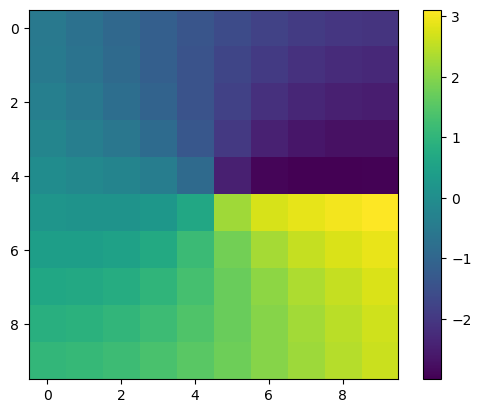

In [70]:
from scipy.optimize import minimize 

# Init parameters
parameters = np.random.uniform(-np.pi, np.pi, (resolution, resolution)).flatten()

# Optimizer
tic = time.perf_counter()
res = minimize(loss, parameters, method='BFGS', options={'disp': True})
print("Time taken to optimize one sample - in seconds", time.perf_counter() - tic)

result = (res.x).reshape(resolution, resolution)

# Wrap phase (-pi, pi):
plt.imshow(np.arctan2(np.cos(result), np.sin(result)))
plt.colorbar()